# Steam Review Analysis

Let's start by importing some libraries we will be making use of

In [1]:
import pandas as pd
import numpy as np
import requests

In [2]:
# For cleaner printing of DataFrames
pd.set_option('display.max_colwidth', 10)

### Obtaining the Data
Here we have a function to gather steam reviews

*Each call returns a json list with data for up to 100 reviews and a 'cursor' attribute value. When used as a parameter in the next call, it indicates the start point so that we can fetch the next set of reviews*

Input:
* ***appid*** : The unique integer ID of the application we want reviews for
* ***num_reviews*** : The number of reviews to fetch 

Return:
* A list of dictionaries containing the reviews


In [3]:
def get_reviews(appid: int, num_reviews: int):
    base_url = "https://store.steampowered.com/appreviews/" + str(appid)
    params = {'json': 1,
              'filter': 'recent',
              'language': 'english',
              'cursor': '*',
              'purchase_type': 'all',
              'num_per_page': min(100, num_reviews)
              }
    reviews = []

    while num_reviews > 0:
        response = requests.get(base_url, params=params).json()
        reviews += response['reviews']
        num_reviews -= response['query_summary']['num_reviews']

        params['cursor'] = response['cursor']  # change the cursor parameter to load the next 100 reviews
        params['num_per_page'] = min(100, num_reviews)

        if response['query_summary']['num_reviews'] < 100: break

    return reviews

## Loading the data into a DataFrame

The data we get back is nested awkwardly so I wrote a short function which flattens it and creates a DataFrame from it.

Input:
* **reviews** : A list of review dictionaries as obtained from the *get_reviews()* function

Return:
* A Pandas DataFrame containing the review data

In [4]:
def reviews_to_df(reviews: list):
    df = pd.json_normalize(reviews)
    df.columns = df.columns.str.replace('author.', '', regex=False)
    return df

### Note:
Obtaining review data with `get_reviews()` can take a considerable amount of time for a large number of reviews, since we have to loop through a long sequence of API calls.

To save time, I would strongly recommend making a local copy of the data to load in.

## Example

In [5]:
example_reviews = get_reviews(400, 20)
example_df = reviews_to_df(example_reviews)
example_df['weighted_vote_score'] = example_df['weighted_vote_score'].apply(float) # prevents issues with type conversion
example_df.to_feather(path='./data/example/example_reviews.feather')

example_df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played
0,117682778,english,,165627...,165627...,True,0,0,0.0,0,True,False,False,765611...,112,2,488,10,480,165627...
1,117682711,english,Extrem...,165627...,165627...,True,0,0,0.0,0,True,False,False,765611...,24,2,469,469,469,165627...
2,117679999,english,One of...,165627...,165627...,True,0,0,0.0,0,True,False,False,765611...,90,2,220,220,220,165627...
3,117679356,english,the ca...,165627...,165627...,True,0,0,0.0,0,True,False,False,765611...,21,11,201,201,201,165627...
4,117679112,english,This g...,165627...,165627...,True,0,0,0.0,0,True,False,False,765611...,7,3,172,113,172,165627...


## How has the balance of positive/negative changed since the release of Elden Ring?

The main dataset I will be analysing contains all the English 'Elden Ring' reviews created up to 03/06/2022. This is about 215,000 records

First, we load the data and keep what is relavent for the question

In [6]:
df = pd.read_feather(path='./data/ER_reviews.feather')

df = df[['timestamp_updated', 'voted_up']]  # keep relevant columns
df['timestamp_updated'] = df['timestamp_updated'].dt.floor('d')  # simplify time to day
df

,timestamp_updated,voted_up
0,2022-06-03,True
1,2022-06-03,True
2,2022-06-03,True
3,2022-06-03,True
4,2022-06-03,False
...,...,...
214990,2022-02-28,False
214991,2022-02-28,True
214992,2022-02-28,True
214993,2022-02-28,True


We then group the data by date (specifically, the day the review was last updated) and add some new columns:

* **positive:** The number of positive reviews created on that date
* **negative:** The number of negative reviews created on that date
* **% positive:** The percentage of reviews that are positive on that given day
* ***x*DayMA:** A moving average of '% positive' for the past *X* days 

In [7]:
df = df.groupby('timestamp_updated').agg(num_votes=('voted_up', 'count'), positive=('voted_up', 'sum'))

df['negative'] = df['num_votes'] - df['positive'] # new column with negative review count
df['% positive'] = df['positive']/df['num_votes'] # new column with % of reviews that are positive on that date

# Moving averages
df['7DayMA'] = df['% positive'].rolling(7).mean()
df['20DayMA'] = df['% positive'].rolling(20).mean()
df['30DayMA'] = df['% positive'].rolling(30).mean()

df

,num_votes,positive,negative,% positive,7DayMA,20DayMA,30DayMA
timestamp_updated,,,,,,,
2022-02-28,4651,4295,356,0.923457,NaN,NaN,NaN
2022-03-01,7365,6836,529,0.928174,NaN,NaN,NaN
2022-03-02,8974,8498,476,0.946958,NaN,NaN,NaN
2022-03-03,6431,5923,508,0.921008,NaN,NaN,NaN
2022-03-04,6733,6261,472,0.929898,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-05-30,494,446,48,0.902834,0.904626,0.913197,0.916940
2022-05-31,443,418,25,0.943567,0.909791,0.914498,0.917982
2022-06-01,424,384,40,0.905660,0.909330,0.914414,0.917669


### Plotting the data

To plot the data we will need an additional library:

In [8]:
import matplotlib.pyplot as plt

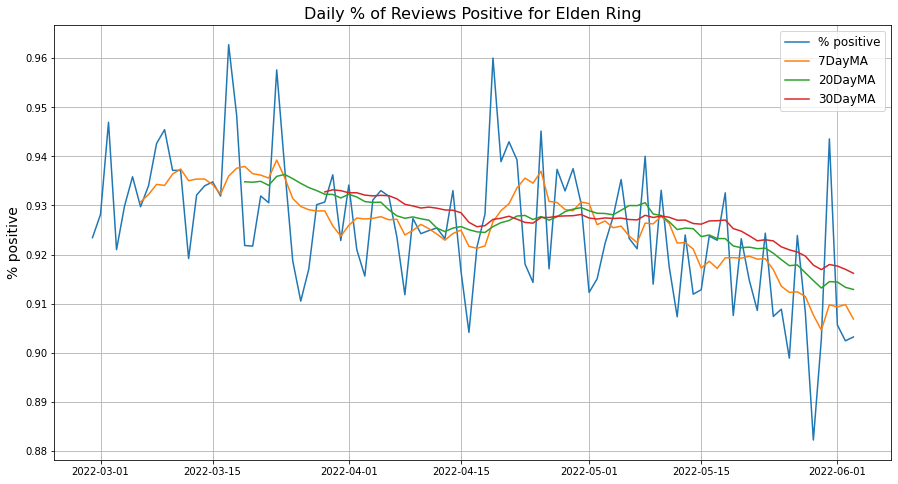

In [9]:
# columns to plot
to_plot = ['% positive', '7DayMA', '20DayMA', '30DayMA']

# plotting
plt.figure(figsize=(15, 8))
plt.plot(df[to_plot])

plt.title("Daily % of Reviews Positive for Elden Ring", fontsize=16)
plt.ylabel("% positive", fontsize=14)
plt.legend(to_plot, prop={'size': 12})
plt.grid()

plt.show()

There seems to be a slight downtrend, however I think more data is needed to be able to draw a concrete conclusion.

A slight decrease in the percentage of reviews that are positive overtime has a logical explanation though. There is often a lot of hype surrounding a game's release. While things are new and exciting, people may be more inclined to give a positive review.

### Looking on a 7 day timeframe

In [10]:
df = pd.read_feather(path='./data/ER_reviews.feather')

df = df[['timestamp_updated', 'voted_up']]  # keep relevant columns
df['timestamp_updated'] = df['timestamp_updated'].dt.to_period('W').dt.start_time  # convert timestamp to first day of week

# group and add new columns
df = df.groupby('timestamp_updated').agg(num_votes=('voted_up', 'count'), positive=('voted_up', 'sum'))
df['negative'] = df['num_votes'] - df['positive']
df['% positive'] = df['positive']/df['num_votes']

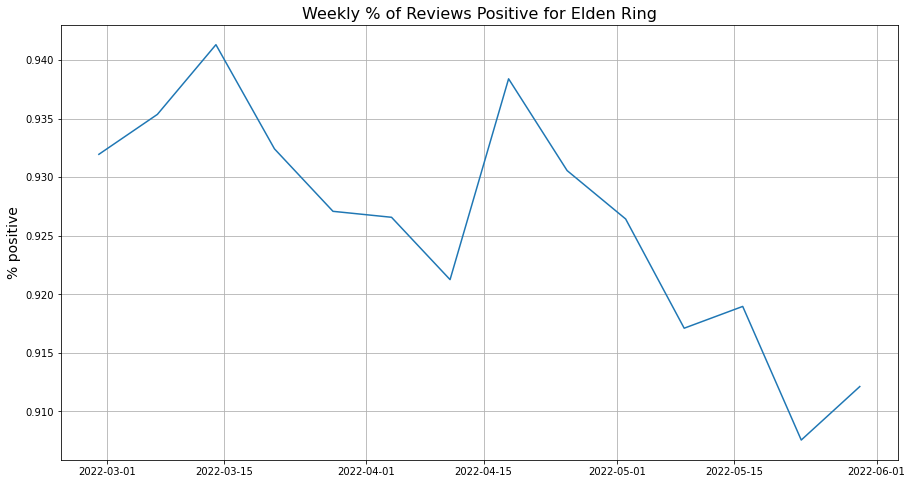

In [11]:
# plotting
plt.figure(figsize=(15, 8))
plt.plot(df['% positive'])

plt.title("Weekly % of Reviews Positive for Elden Ring", fontsize=16)
plt.ylabel("% positive", fontsize=14)
plt.grid()

plt.show()

Using a 7 day timeframe helps us see a more general long term trend because daily oscillations have less of an impact. I still believe that more data is required though, especially when considering a 7 day timeframe, as there are even fewer data points plotted

## Comparing Distribution of positive/negative reviews


In [12]:
df = pd.read_feather(path='./data/ER_reviews.feather')
df = df[['voted_up', 'playtime_at_review']]
df['playtime_at_review'] = df['playtime_at_review']/60 # convert playtime to hours

# prepare two dataframes with positive and negative reviews
positive_df = df[df['voted_up']]
negative_df = df[~df['voted_up']]

df.head()

,voted_up,playtime_at_review
0,True,683.08...
1,True,11.783333
2,True,32.733333
3,True,87.316667
4,False,4.033333


In [13]:
# Summary Statistics for Positive Reviews
positive_df.describe() 

,playtime_at_review
count,200370...
mean,70.256225
std,69.535991
min,0.083333
25%,23.266667
50%,51.150000
75%,97.333333
max,2151.3...


In [14]:
# Summary Statistics for Negative Reviews
negative_df.describe() 

,playtime_at_review
count,14625....
mean,50.956554
std,73.608958
min,0.083333
25%,4.033333
50%,21.800000
75%,72.566667
max,1044.8...


### Boxplot With Outliers

There are a lot of outliers, making it difficult to view the bulk of the data. I have shown it below for completeness however.


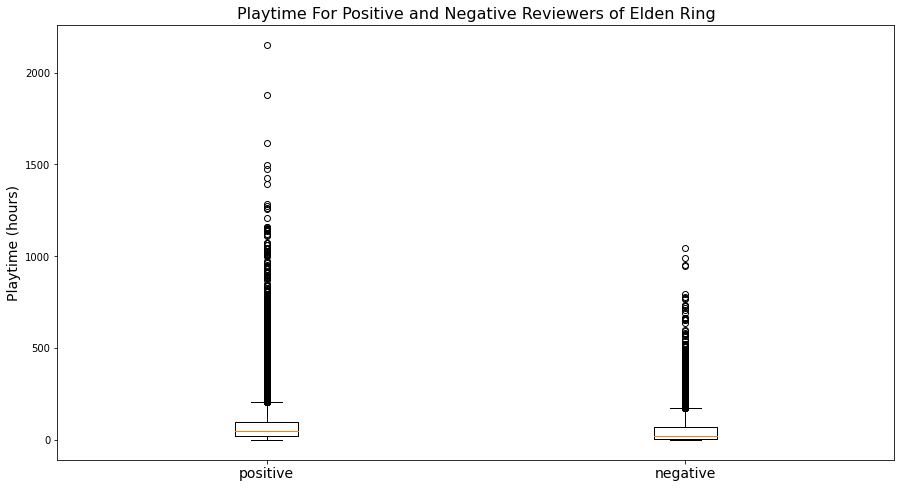

In [15]:
# plotting
plt.figure(figsize=(15, 8))
plt.boxplot([positive_df['playtime_at_review'], negative_df['playtime_at_review']],
            labels=['positive', 'negative'])

plt.title("Playtime For Positive and Negative Reviewers of Elden Ring", fontsize=16)
plt.ylabel('Playtime (hours)', fontsize=14)
plt.xticks(fontsize=14)

plt.show()

### Boxplot Without Outliers

Ignoring the outliers, we can get a clearer view of the data. 

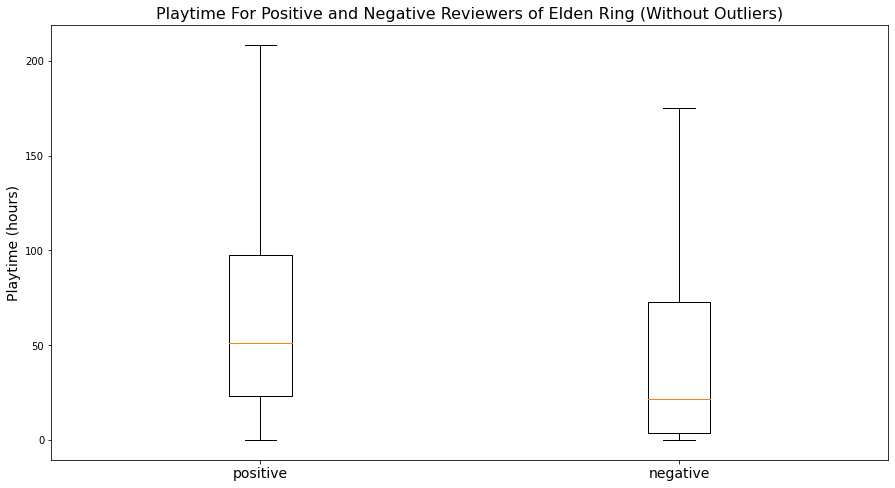

In [16]:
# plotting
plt.figure(figsize=(15, 8))
plt.boxplot([positive_df['playtime_at_review'], negative_df['playtime_at_review']],
            labels=['positive', 'negative'],
            showfliers=False)

plt.title("Playtime For Positive and Negative Reviewers of Elden Ring (Without Outliers)", fontsize=16)
plt.ylabel('Playtime (hours)', fontsize=14)
plt.xticks(fontsize=14)

plt.show()

The median and upper and lower quartiles are greater for the set of players who gave a positive review. This is not too surprising since people who enjoy it are more likely to play for longer. 

Something that is perhaps a little more interesting though, among those who left a negative review, the 50% of people played for 21.8 hours or more and 25% played for 72.5 or more. This seems like quite a significant amount of time for people who would not recommend the game. Here are a few possible reasons why:

* **Sunk cost:** Once a person has spent money on the game (and can't get a refund), they may play it even if they do not enjoy it in an attempt to feel their money has not gone to waste.

* **Novelty:** Initially people may view it more favourably as it is new and exciting. Once this initial "buzz" wears off though, a person's opinion of it may fall.

* **Decreasing quality:** Perhaps the later sections of the game are just poor in quality and it is no more complicated than that. This may be common in games where development is rushed. 

There are just a few of plenty of feasible explanations. Later on we will see if we can draw any insight from the actual reviews themselves.

# Analysing Review Content

In this section we will be focussed on analysing the differences in words present between positive and negative reviews. To do this first we will import some new tools we are going to need

In [17]:
import nltk
from nltk.tokenize import word_tokenize

Additional packages are required for some of the tools we will make use of later on.
These commands must be run before the upcoming code, otherwise it will fail.

```
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
```

One of the things we just downloaded are "stop words". These are words to be filtered out of text as they don't provide any value when analysing it. A couple of common examples of these include "I" or "the".

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

### Word Counts For a Series of Reviews
Here we have a function which filters out stop words, punctuation and numbers to increase the amount of relevant data we receive.

Input:
* **series** : A Pandas Series of review strings
* **stop_words**: A set of "stop words" to be filtered out

Return:
* An nltk FreqDist Object 

In [19]:
def raw_frequency_count(series, stop_words):
    counter = nltk.FreqDist()
    for r in series:
        word_list = [w.casefold() for w in word_tokenize(r) if w.casefold() not in stop_words]  # remove stopwords
        word_list = [w for w in word_list if w.isalpha()]  # keep only words made of letters
        counter.update(word_list)
    return counter

In [20]:
# setup DataFrames to use
df = pd.read_feather(path='./data/ER_reviews.feather')
df = df[['review', 'voted_up']]
df = df[df['review'].str.len() != 0]  # remove blank review entries

# split the reviews by positive/negative
positive_df = df[df['voted_up']]
negative_df = df[~df['voted_up']]

In [21]:
# obtain the word frequencies
pos_freq_test = raw_frequency_count(positive_df.loc[:1000, 'review'], stop_words)
neg_freq_test = raw_frequency_count(negative_df.loc[:1000, 'review'], stop_words)

In [22]:
pos_freq_test.most_common(10)

[('game', 626),
 ('good', 182),
 ('souls', 124),
 ('games', 109),
 ('like', 109),
 ('one', 97),
 ('fun', 93),
 ('world', 84),
 ('best', 74),
 ('get', 74)]

In [23]:
pos_freq_test.most_common(10)

[('game', 626),
 ('good', 182),
 ('souls', 124),
 ('games', 109),
 ('like', 109),
 ('one', 97),
 ('fun', 93),
 ('world', 84),
 ('best', 74),
 ('get', 74)]

These frequency counts can be improved on depending on what we want to use them for. Here are some potential issues:

* There are repeated words in different forms. e.g. "game" and "games"

* Some words depend on context. e.g. "like" can be used positively or negatively, "I like" VS "I do not like" 

* Some words may not be useful for what you are investigating

We will try to address each of these problems


## Lemmatizing words
This is one way of reducing repeated words in different forms. I have modified our function from earlier to lemmatize each word before counting it. 

The function also now accepts a list of words not to lemmatize because in some cases, it doesn't make sense to. For example, 'Souls' is a genre of game (i.e. similar to the video game "Dark Souls") so reducing it to soul is not useful here.

In [24]:
from nltk.stem import WordNetLemmatizer

In [25]:
def lem_frequency_count(series, stop_words, do_not_lem=[]):
    counter = nltk.FreqDist()
    wnl = WordNetLemmatizer()
    for r in series:
        word_list = [w.casefold() for w in word_tokenize(r) if w.casefold() not in stop_words]  # remove stopwords
        word_list = [w for w in word_list if w.isalpha()]  # keep only words made of letters
        word_list = [wnl.lemmatize(w) if w not in do_not_lem else w for w in word_list] # lemmatize
        counter.update(word_list)
    return counter

In [26]:
do_not_lem = ['souls', 'boss']

pos_freq_test = lem_frequency_count(positive_df.loc[:1000, 'review'], stop_words, do_not_lem)
neg_freq_test = lem_frequency_count(negative_df.loc[:1000, 'review'], stop_words, do_not_lem)

In [27]:
pos_freq_test.most_common(10)

[('game', 735),
 ('good', 182),
 ('souls', 124),
 ('like', 111),
 ('one', 100),
 ('fun', 93),
 ('boss', 89),
 ('world', 88),
 ('get', 79),
 ('time', 78)]

In [28]:
neg_freq_test.most_common(10)

[('game', 205),
 ('like', 58),
 ('get', 35),
 ('boss', 35),
 ('time', 34),
 ('even', 29),
 ('would', 25),
 ('one', 22),
 ('souls', 21),
 ('make', 21)]

This has cleaned up our results a little; we no longer see 'game' and 'games' both appearing in the list. There are many different options for lemmatization, we may still find some repeated words however our new function should be sufficient. 

## Comparing Word Counts
Since we have a lot of reviews, calculating word counts can take time so I will load the data obtained when the code is run from a file instead. The following demonstrates how to obtain and save the data:

In [29]:
# EXAMPLE USE
example_counts = lem_frequency_count(positive_df.loc[:10, 'review'], stop_words, do_not_lem)
example_counts = list(example_counts.items())
example_df = pd.DataFrame(example_counts, columns=['word', 'count'])
example_df.to_feather(path='./data/Example/example_counts.feather')

In [30]:
# Load in word count data from file
df_pos_counts = pd.read_feather(path='./data/ER_pos_counts.feather')
df_neg_counts = pd.read_feather(path='./data/ER_neg_counts.feather')

# Sort so the most frequent words appear first
df_pos_counts = df_pos_counts.sort_values(by='count', ascending=False)
df_neg_counts = df_neg_counts.sort_values(by='count', ascending=False)

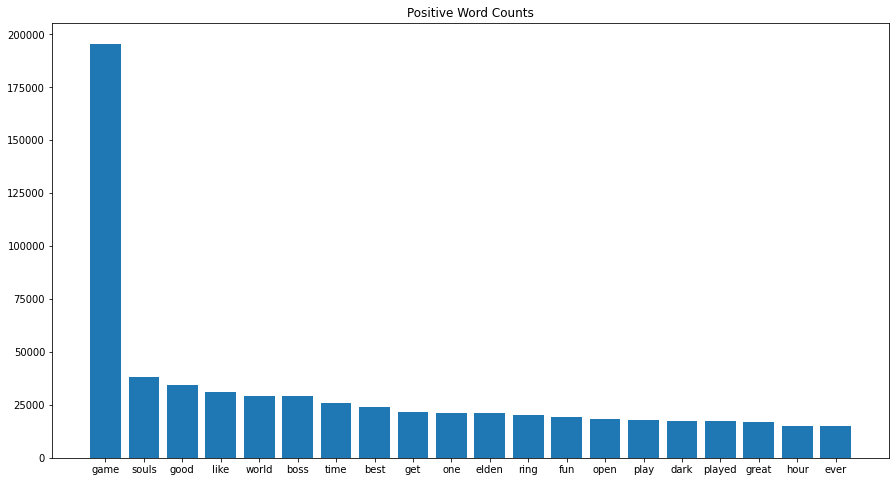

In [31]:
# Plot bar chart for positive counts
plt.figure(figsize=(15, 8))
plt.bar(df_pos_counts['word'].iloc[:20], df_pos_counts['count'].iloc[:20])
plt.title('Positive Word Counts', fontsize=16)
plt.show()

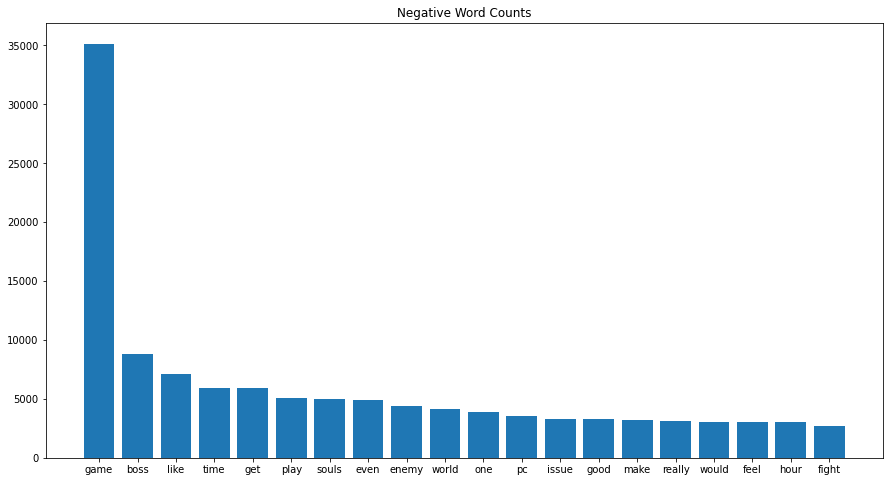

In [32]:
# Plot negative counts
plt.figure(figsize=(15, 8))
plt.bar(df_neg_counts['word'][:20], df_neg_counts['count'][:20])
plt.title('Negative Word Counts', fontsize=16)
plt.show()

# Bigram Counts

We can also look at the most frequent combinations of consecutive words; "bigrams" are pairs of words. This is one potential way to address the issue where a word's sentiment can depend on context, since we see some of what surrounds it. 

Here is a function to obtain the bigram counts of our reviews. The inputs and outputs are the same as before but this time we receive a nltk FreqDist object containing bigrams instead of words.

In [33]:
def bigram_count(series, stop_words):
    counter = nltk.FreqDist()
    for r in series:
        word_list = [w.casefold() for w in word_tokenize(r) if w.casefold() not in stop_words]  # remove stopwords
        word_list = [w for w in word_list if w.isalpha()]  # keep only words made of letters
        bgs = nltk.bigrams(word_list)  # convert word_list to bigrams
        counter.update(bgs)
    return counter

In [34]:
# EXAMPLE USE
example_bgs = bigram_count(positive_df.loc[:5, 'review'], stop_words)
example_bgs = list(example_bgs.items())
example_df = pd.DataFrame(example_bgs, columns=['bigram', 'count'])
example_df.to_feather(path='./data/example/example_bigrams.feather')

In [35]:
# Load in bigram counts from file
pos_bgs_df = pd.read_feather(path='./data/ER_pos_bigrams.feather')
neg_bgs_df = pd.read_feather(path='./data/ER_neg_bigrams.feather')

# Sort so the most frequent bigrams appear first
pos_bgs_df = pos_bgs_df.sort_values(by='count', ascending=False)
neg_bgs_df = neg_bgs_df.sort_values(by='count', ascending=False)

# Shorten the DataFrames to save time
pos_bgs_df = pos_bgs_df.iloc[:1000]
neg_bgs_df = neg_bgs_df.iloc[:1000]

# Create a label column 
pos_bgs_df['label'] = pos_bgs_df['bigram'].apply(lambda x: " ".join(x))
neg_bgs_df['label'] = neg_bgs_df['bigram'].apply(lambda x: " ".join(x))

print(pos_bgs_df)

          bigram  count      label
121    [elden...  19131  elden ...
20     [open,...  16729  open w...
445    [dark,...  16236  dark s...
1      [souls...  14591  souls ...
27     [best,...  12395  best game
...          ...    ...        ...
12109  [amazi...    168  amazin...
2111   [there...    168  theref...
7013   [atten...    168  attent...
12457  [nothi...    167  nothin...
2434   [watch...    167  watch ...

[1000 rows x 3 columns]


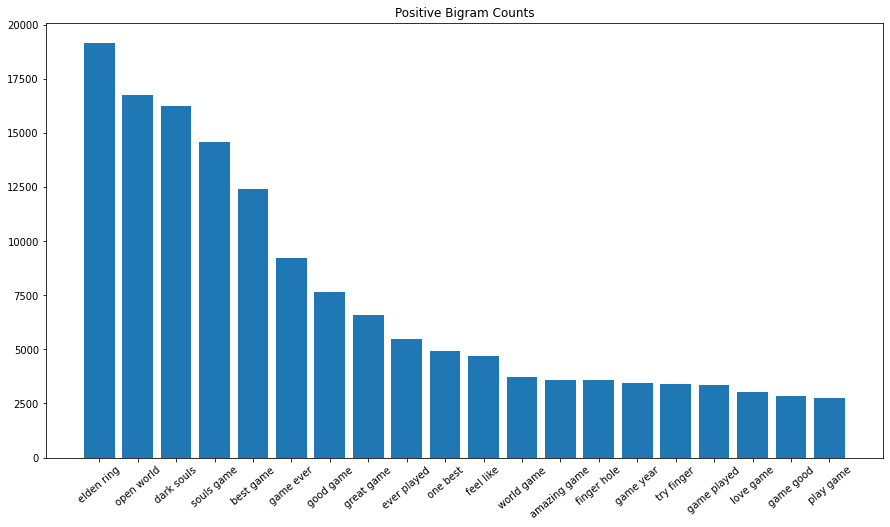

In [36]:
# Plot bar chart for positive bigram counts
plt.figure(figsize=(15, 8))
plt.bar(pos_bgs_df['label'].iloc[:20], pos_bgs_df['count'].iloc[:20])

plt.title('Positive Bigram Counts')
plt.xticks(rotation=40, fontsize=16)

plt.show()

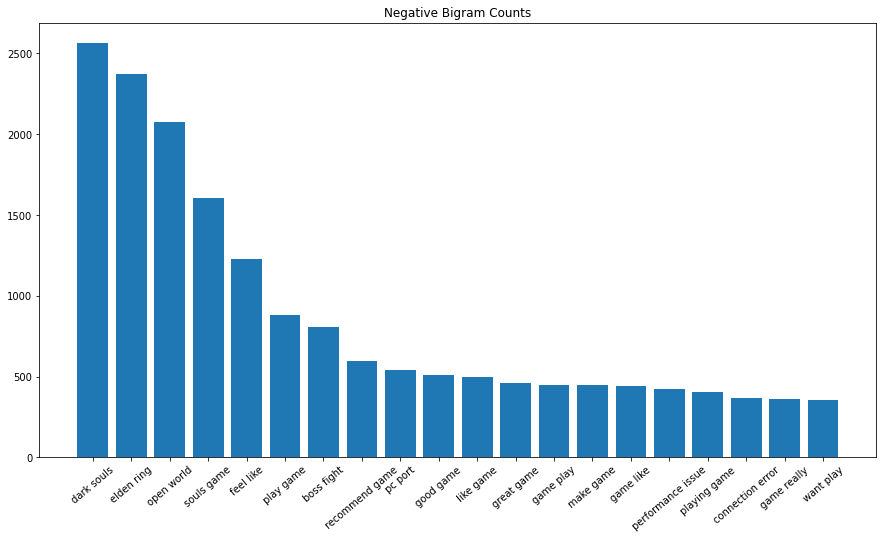

In [37]:
# Plot bar chart for negative bigram counts
plt.figure(figsize=(15, 8))
plt.bar(neg_bgs_df['label'].iloc[:20], neg_bgs_df['count'].iloc[:20])

plt.title('Negative Bigram Counts')
plt.xticks(rotation=40, fontsize=16)

plt.show()

Analysing frequency counts of bigrams as opposed to just words can bring to light things we may otherwise miss. For example, there a few clear leads as to the cause of the negative reviews. We see bigrams such as "performance issue" and "connection error" which are specific problems that could be investigated in more detail.

# Sentiment Analysis

First we will test the accuracy of nltk's vader classifier on our reviews

In [38]:
from nltk.sentiment import SentimentIntensityAnalyzer 

In [39]:
# Example of how the full sentiment data was produced
df_sent_example = pd.read_feather(path='./data/ER_reviews.feather')
df_sent_example = df_sent_example.loc[:10,:]

sia = SentimentIntensityAnalyzer()

# creates a dictionary of vader scores for each row
sia_scores = df_sent_example['review'].apply(lambda x: sia.polarity_scores(x))

# create columns with the individual scores
df_sent_example['vader_neg'] = sia_scores.apply(lambda x: x['neg'])
df_sent_example['vader_neu'] = sia_scores.apply(lambda x: x['neu'])
df_sent_example['vader_pos'] = sia_scores.apply(lambda x: x['pos'])
df_sent_example['vader_compound'] = sia_scores.apply(lambda x: x['compound'])

df_sent_example.to_feather(path='./data/example/example_sentiment.feather')

Here we have a simple function to help determine if the classification is correct.

If the classification is correct, it will return a value which matches that of the 'voted_up' column. We can compare the two columns to find how accurate the Vader Classifier is for our dataset.

In [40]:
def classification(score):
    if score != 0: return score > 0

In [41]:
df_sent = pd.read_feather('./data/ER_sentiment.feather')

# calculates the percentage of reviews where the classification matches whether it is actually positive/negative
sum(df_sent['vader_compound'].apply(classification) == df_sent['voted_up'])/len(df_sent)

0.6191492825414544

Here we see that the Vader Classifier is approximately 61.9% accurate over our whole dataset. Here are a few potential explanations for this somewhat poor performance:

* 1) The presence of joke reviews which aren't intended to give a serious critique of the game

* 2) Reviews could be too short for the classifier to decipher the sentiment

### Classifying "Helpful" Reviews
Let's see if the classifier is more accurate for reviews which have been marked as helpful by the community. We sort the reviews by "votes_up" (how many people have voted a review as helpful) and then take the 20,000 reviews with the highest values.

In [42]:
df_sent = pd.read_feather('./data/ER_sentiment.feather')
df_sent = df_sent.sort_values(by="votes_up",ascending=False)
df_sent = df_sent.iloc[:20000]  # 20,000 most helpful reviews

# calculates the percentage of reviews where the classification matches whether it is actually positive/negative
sum(df_sent['vader_compound'].apply(classification) == df_sent['voted_up'])/len(df_sent)

0.5862

When looking at "helpful" reviews the classifier performs even more poorly with an accuracy of only approximately 58.6%.

### Classifying Longer Reviews
To test the case where the reviews are too short, let's see how it performs on the longest reviews. We sort the reviews by length and then take the first 20,000 reviews.

In [43]:
df_sent = pd.read_feather('./data/ER_sentiment.feather')
df_sent = df_sent.sort_values(by="review", key=lambda x: x.str.len(), ascending=False)
df_sent = df_sent.iloc[:20000]  # 20,000 longest reviews

# calculates the percentage of reviews where the classification matches whether it is actually positive/negative
sum(df_sent['vader_compound'].apply(classification) == df_sent['voted_up'])/len(df_sent)

0.75085

When looking at the 20,000 longest reviews, the classifier has 75.1% accuracy which is quite a significant improvement. This could suggest that the shorter reviews don't give the classifier enough information for it to work effectively.

## Building a New Classifier
We will now attempt to build a new classifier with higher accuracy. The features we will be using are:
* Vader Compound Score
* Vader Positive Score
* Playtime at review

I decided to use playtime as a feature since the values among positive reviewers were generally higher as shown earlier. 

Here we have a function to set up the reviews for use in a classifier. It returns a list of tuples containing two things: a dictionary with the features, and the label.

In [44]:
def extract_features(df):
    feature_list = []
    classification_dict = {True: "pos",
                           False: "neg"}

    for row in df.itertuples():
        features = {"vader_compound": row.vader_compound,
                    "vader_positive": row.vader_pos,
                    "playtime": row.playtime_at_review}
        
        classification = classification_dict[row.voted_up]
        
        feature_list.append((features, classification))
        
    return feature_list

In [45]:
# prepare features
df = pd.read_feather('./data/ER_sentiment.feather')
features = extract_features(df)

In [46]:
# Show the layout of features
features[:2]

[({'vader_compound': 0.5719, 'vader_positive': 0.381, 'playtime': 40985},
  'pos'),
 ({'vader_compound': 0.5396, 'vader_positive': 0.205, 'playtime': 707}, 'pos')]

To prevent training our classifier with only the most recent reviews, we use `shuffle` to randomize the ordering

In [47]:
from random import shuffle

In [48]:
# We will use 1/4 of our data to train, and the rest to test how accurate it is
shuffle(features)

n_train = len(features)//4

train_set, test_set = features[:n_train], features[n_train:]

classifier = nltk.NaiveBayesClassifier.train(train_set)

nltk.classify.accuracy(classifier, test_set)

0.9118867327764237

In [49]:
# To verify this result is consistent we can take the mean of several run throughs
n_repeats = 3
acc_list = np.zeros(n_repeats)
n_train = len(features)//4

for i in range(n_repeats):
    shuffle(features)
    classifier = nltk.NaiveBayesClassifier.train(features[:n_train])
    acc_list[i] = nltk.classify.accuracy(classifier, features[n_train:])
    
acc_list.mean()

0.9117523633514629

With 91% accuracy, our classifier seems to have performed well but I don't believe it is as effective as its accuracy would suggest. There is a large imbalance in the number of reviews; approximately 93% of our reviews are positive. This means that if the classifier simply labels everything as 'positive', it will obtain this accuracy of 93%. 

To counteract this we need to train and test the classifier again, but this time using a roughly even amount of positive and negative reviews. This way, if the classifier were to label everything the same, we would only receive 50% accuracy.


In [50]:
# Shows the split of positive and negative reviews
df['voted_up'].value_counts(normalize=True)

True     0.931975
False    0.068025
Name: voted_up, dtype: float64

In [51]:
# prepare the positive and negative features lists separately
pos_features = extract_features(df[df['voted_up']])
neg_features = extract_features(df[~df['voted_up']])

n_train = len(neg_features)//4

# shuffle the features so they aren't chronological
shuffle(pos_features)
shuffle(neg_features)

# prepare the train and test sets.
# note that we train with the same number of pos and neg but test with the 
# remainder which contains far more positive
train_set = pos_features[:n_train] + neg_features[:n_train]
test_set = pos_features[n_train:] + neg_features[n_train:]

classifier = nltk.NaiveBayesClassifier.train(train_set)

nltk.classify.accuracy(classifier, test_set)

0.7319665066471498

After making the changes described earlier to the training set, we receive an average accuracy of approximately 73%. The accuracy varies a lot more when training and testing in this way. Perhaps this is due to the fact we are using a much smaller proportion of the reviews in the training set. 

This is quite a significant improvement on the accuracy we received using the 'vader_compound' score alone, with a jump from 62% to 73%.